# Moving Average (MA) Model
## MA model defintion
- Moving Average (MA) model, denoted as $MA(q)$ where $q$ is the order, expresses the present value as a linear combination of
    - The **mean** of the series ($\mu$)
    - The *current* ($\epsilon_t$) & *past* ($\epsilon_{t-q}$) **error terms**
        - Those error terms are assumed to be *mutually independent* and *normally distributed*, just like white noise.
        - The *magnitude of the impact* of **past errors on the present value** is quantified using a coefficient denoted as ($\theta_q$).
    $$y_t = \mu + \epsilon_t + \theta_1\epsilon_{t-1} + ... + \theta_q\epsilon_{t-q}$$
    - Note 1: The order $q$ of the moving average model determines the number of past error terms that affect the present value.
    - Note 2: The $MA(q)$ model only forecast $q$ steps into the future as it is linearly dependent on $q$ past error terms.

## Identifying the order of MA model
- Step 1: Test for stationarity. 
    - If our series is not stationary, we apply transformations, such as differencing, until the series is stationary. 
- Step 2: Plot the ACF and look for significant autocorrelation coefficients. 
    - In the case of a random walk, we will not see significant coefficients after lag 0. 
    - If we see significant coefficients, we must check whether they become abruptly non-significant after some lag $q$. 
        - If that is the case, then we know that we have a moving average process of order $q$. 
    - Otherwise, we must follow a different set of steps to discover the underlying process of our time series.

<p align="center"><img src="../../assets/img/moving-average-identification-framework.png" height=500><br>Steps to identify the order of a moving average (MA) process</p>

- Goal: forecast the volume of widget sales so that the company will be able to better manage its production of widgets and avoid producing too many or too few.
- Timeline: the sales of widgets over 500 days starting in 2019 

In [87]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf

import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, mean_absolute_error

import plotly.graph_objects as go
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv("../../data/book-time-series-forecasting-in-python/widget_sales.csv")
df.head()

,widget_sales
0,50.496714
1,50.805493
2,51.477758
3,53.542228
4,54.873108


In [12]:
fig = px.line(df['widget_sales'])
fig.update_layout(
    xaxis= dict(
        tickmode = 'array',
        tickvals = [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498],
        ticktext = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb', 'Mar', 'Apr', 'May','Jun']
    ),
    yaxis_title='Widget sales (k$)',
    xaxis_title='Time',
    title='Widget Sales over 500 days since the start of 2019'
)  

In [15]:
def check_stationarity(series, p_significant=0.05):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    adfuller_result = adfuller(series)
    kpss_result = kpss(series)

    print(f'ADF Statistic : {adfuller_result[0]:.5f}, p-value: {adfuller_result[1]:.5f}')
    print('Critical Values:')
    for key, value in adfuller_result[4].items():
        print('\t%s: %.3f' % (key, value))
    print(f'KPSS Statistic: {kpss_result[0]:.5f}, p-value: {kpss_result[1]:.5f}')
    if (adfuller_result[1] <= p_significant) & (adfuller_result[4]['5%'] > adfuller_result[0]) & (kpss_result[1] > p_significant):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [18]:
check_stationarity(df['widget_sales'])

ADF Statistic : -1.51217, p-value: 0.52748
Critical Values:
	1%: -3.444
	5%: -2.867
	10%: -2.570
KPSS Statistic: 2.87187, p-value: 0.01000
Non-stationary


- The time series is not stationary, so we try to stabilize the trend by applying a first-order differencing. 

In [20]:
widget_sales_diff = np.diff(df['widget_sales'], n=1)

In [21]:
check_stationarity(widget_sales_diff)

ADF Statistic : -10.57666, p-value: 0.00000
Critical Values:
	1%: -3.444
	5%: -2.867
	10%: -2.570
KPSS Statistic: 0.12472, p-value: 0.10000
Stationary


- From the ACF plot, there are significant coefficients up until lag 2. Then they abruptly become non-significant, as they remain in the shaded area of the plot.
- This means that we have a stationary moving average process of order 2. 

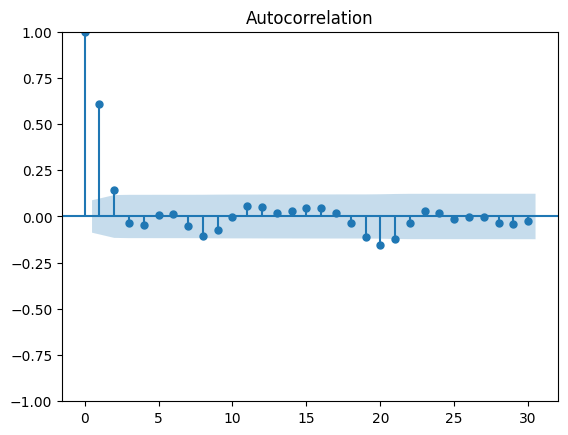

In [23]:
plot_acf(widget_sales_diff, lags=30);

## Forecasting a moving average process

- The moving average model assumes stationarity, meaning that our forecasts must be done on a stationary time series.
    - Therefore, we will train and test our model on the **differenced volume of widget sales**
- The moving average model is linearly dependent on past error terms, this means that for an $MA(q)$ model, we can only forecast $q$ steps into the future. 
    - Any prediction made beyond that point will not have past error terms, and the model will only predict the mean, which is equivalent to a baseline model.
- **Rolling forecast function**: the prediction loop starts at the end of the training set and continues until `total_len`, each pass in the loop, the model will predict `window` values (in this MA(2) example will be 2 forecasts), and then re-fit model with addtional `window` steps before predicting the next `window` values.
    - The `train_len` parameter is the size of training set
    - The `horizon` parameter is equal to the length of the test set and represents how many values must be predicted.
    - The `window` parameter specifies how many timesteps are predicted at a time. 
        - In our case, because we have an $MA(2)$ process, the window will be equal to 2.
    - The `method` parameter specifies what model to use: Naive methods and the MA(2) model.

In [67]:
df.shape

(500, 1)

In [68]:
widget_sales_diff.shape # the first value in "df" (total 500 records) will be removed from "df_diff" (total 499 records)

(499,)

In [24]:
df_diff = pd.DataFrame({'widget_sales_diff': widget_sales_diff})   
 
train = df_diff[:int(0.9*len(df_diff))] # df_dff[:449]                           
test = df_diff[int(0.9*len(df_diff)):]  # df_diff[499:]                          
print(len(train))
print(len(test))

449
50


In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# MA(q) model is part of the more complex SARIMAX model

In [39]:
def rolling_forecast(df: pd.DataFrame,
                     train_len: int, # training length
                     horizon: int,   # horizon of the forecast
                     window: int,    # how many steps to forecast
                     method: str) -> list:
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
        return pred_mean
    
    if method == 'last':
        pred_last_value = []
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
        return pred_last_value
    
    elif method == 'MA':
        pred_MA = []
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0,0, window))  # MA(2) as window=2               
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1) # forecast to the next "window" steps
            # "predicted_mean" method allows us to retrieve the actual value of the forecast 
            # as defined by the statsmodels library.
            oos_pred = predictions.predicted_mean.iloc[-window:]    
            pred_MA.extend(oos_pred)
            
        return pred_MA

In [40]:
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

In [43]:
pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'MA') # MA(2)

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_MA'] = pred_MA

In [104]:
pred_df.head()

,widget_sales_diff,pred_mean,pred_last_value,pred_MA
449,-1.170131,0.034319,-1.803658,-1.078833
450,0.580967,0.034319,-1.803658,-0.273309
451,-0.144902,0.032861,0.580967,0.781223
452,-0.096564,0.032861,0.580967,0.234969
453,-0.372334,0.032183,-0.096564,0.168994


In [60]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_diff[-70:].index, y=df_diff[-70:]['widget_sales_diff'], name='actual', line = dict(color='royalblue')))

for pred_type in ["pred_mean", "pred_last_value","pred_MA"]: 
    fig.add_trace(go.Scatter(x=pred_df.index, y=pred_df[pred_type], name=pred_type, line = dict(dash='dash')))
fig.update_layout(
    xaxis= dict(
        tickmode = 'array',
        tickvals = [439, 468, 498],
        ticktext = ['Apr', 'May', 'Jun']
    ),
    yaxis_title='Widget sales - Diff (k$)',
    xaxis_title='Time',
    title='Widget Sales (Diff) on Test Set'
)  
fig.show()

- The historical `mean`, shown as a dotted line (orange), is almost a straight line. This is expected; the process is stationary, so the historical mean should be stable over time.

In [62]:
# measure the performance of our models.
mse_mean = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_last_value'])
mse_MA = mean_squared_error(pred_df['widget_sales_diff'], pred_df['pred_MA'])

print(mse_mean, mse_last, mse_MA)

2.5606299456880537 3.2494260812249225 1.9481714497384723


- $MA(2)$ model is the best-performing forecasting method, since its MSE is the lowest of the three methods.

- The champion model is on the stationary series, so we need to inverse-transform our predictions to bring them back to the original scale of the untransformed dataset.
- In order to reverse our first-order difference to the original scale, 
    - For $y_1$, we need to add an initial value $y_0$ to the first differenced value $y_1'$.
    - For $y_2$, we need to add an initial value $y_0$ with a cumulative sum of the differenced values (i.e. sum of $y_1'$ and $y_2'$)
$$y_1 = y_0 + y_1' = y_0 + y_1– y_0 = y_1$$
$$y_2 = y_0 + y_1' + y_2' = y_0 + y_1– y_0 + y_2– y_1 = (y_0– y_0) + (y_1– y_1) + y_2 = y_2$$

<p align="center"><img src="../../assets/img/first-order-differencing.png" height=400><br>Visualizing a first-order difference</p>

- To obtain our predictions in the original scale of our dataset, we need to use the last value in the training set as our initial value. 
- Then we can perform a cumulative sum to obtain a series of 50 predictions in the original scale of the dataset

In [100]:
df['pred_widget_sales'] = pd.Series()
df['pred_widget_sales'].iloc[450:] = df['widget_sales'].iloc[449] + pred_df['pred_MA'].cumsum()

In [102]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df[-70:].index, y=df[-70:]['widget_sales'], name='actual', line = dict(color='royalblue')))
fig.add_trace(go.Scatter(x=df[-70:].index, y=df[-70:]["pred_widget_sales"], name='MA(2) pred', line = dict(dash='dash')))
fig.update_layout(
    xaxis= dict(
        tickmode = 'array',
        tickvals = [439, 468, 498],
        ticktext = ['Apr', 'May', 'Jun']
    ),
    yaxis_title='Widget sales (k$)',
    xaxis_title='Time',
    title='Widget Sales (Actual vs Prediction)'
)  
fig.show()

In [96]:
mae_MA_undiff = mean_absolute_error(df['widget_sales'].iloc[450:], df['pred_widget_sales'].iloc[450:])
print(mae_MA_undiff)

2.7656641098471657


- Use this `mean_absolute_error` metrics because it is easy to interpret, as it returns the average of the absolute difference between the predicted and actual values, instead of a squared difference like the **MSE**.
- Hence, the actual prediction will be either above or below the actual value around $2765